# Example
Comparison between swept wing by Bertin and pySailingVLM results. More information can be found at Aerodynamics for engineers John J.Bertin p 368 (Example 7.2).

In [1]:
# varaibles.py for jupyter
import os
import numpy as np
import time
from pySailingVLM.runner.container import Output, Rig, Conditions, Solver, MainSail, JibSail, Csys, Keel

half_wing_span = 0.5
sweep_angle_deg = 45.
chord_length = 0.2
AoA_deg = 4.
mgirths =  np.array([0.00, 1./8, 1./4, 1./2, 3./4, 7./8, 1.00])
mchords = np.array([chord_length]* len(mgirths))
jgirths = np.array([0.00, 1./4, 1./2, 3./4, 1.00])

out = Output(case_name='my_case_name',
             case_dir=os.path.abspath(''),
             name=os.path.join("results_example_jib_and_mainsail_vlm", time.strftime("%Y-%m-%d_%Hh%Mm%Ss")),
            file_name='my_fancy_results')

solver = Solver(n_spanwise=4,
                n_chordwise=1,
                interpolation_type='linear')

conditions = Conditions(leeway_deg=0.,    
                        heel_deg=0.,    
                        SOG_yacht=0.,  
                        tws_ref= 1.,     
                        alpha_true_wind_deg= AoA_deg, 
                        reference_water_level_for_wind_profile=-0.,
                        wind_exp_coeff=0.,
                        wind_reference_measurment_height=10.,
                        rho=1.,
                        wind_profile='flat',
                        roughness=0.05)

rig = Rig(main_sail_luff=half_wing_span / np.cos(np.deg2rad(sweep_angle_deg)),
          jib_luff=10.0,
          foretriangle_height=11.50,
          foretriangle_base=3.90,
          sheer_above_waterline=0.,
          boom_above_sheer=0.,
          rake_deg=90. + sweep_angle_deg,
          mast_LOA=0.,
          sails_def='main')

main = MainSail(centerline_twist_deg=0*mgirths,
                girths=mgirths,
                chords=mchords,
                camber= 0*np.array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]),
                camber_distance_from_luff=np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]))
              
jib = JibSail(centerline_twist_deg=0*(10+5)  + 0*15. * jgirths,
             girths=jgirths,
             chords=0* np.array([3.80, 2.98, 2.15, 1.33, 0.5]),
             camber=0*np.array([0.01, 0.01, 0.01, 0.01, 0.01]),
             camber_distance_from_luff=np.array([0.5, 0.5, 0.5, 0.5, 0.5]))

csys = Csys(reference_level_for_moments=np.array([0, 0, 0]))
keel = Keel(center_of_lateral_resistance_upright=np.array([0, 0, -1.0]))    


<div class="alert alert-block alert-warning">
<b>Run cell below twice:</b> Run cell below twice before running other cells. Output below is expected to always appear at first time importing pySailingVLM:
<br><br>
    
<em>   
/home/user/miniconda3/envs/mgr_test/lib/python3.10/site-packages/numba/core/lowering.py:107: NumbaDebugInfoWarning: Could not find source for function: <function __numba_array_expr_0x7f01d6a1e9e0 at 0x7f01d6cfa680>. Debug line information may be inaccurate.warnings.warn(NumbaDebugInfoWarning(msg))
</em> 
<br>
</div>

In [2]:
import shutil
from pySailingVLM.rotations.csys_transformations import CSYS_transformations
from pySailingVLM.yacht_geometry.hull_geometry import HullGeometry
from pySailingVLM.results.save_utils import save_results_to_file
from pySailingVLM.solver.panels_plotter import display_panels_xyz_and_winds
from pySailingVLM.results.inviscid_flow import InviscidFlowResults
from pySailingVLM.solver.vlm import Vlm
from pySailingVLM.runner.sail import Wind, Sail
from pySailingVLM.solver.panels_plotter import plot_cp

In [3]:
import numpy as np
from pySailingVLM.solver.coefs import get_vlm_Cxyz

AoA_degs = np.linspace(0.001, 10., 20) # [4.0] #

C_results = []
cl_results = []
a_vlm_results = []
for AoA_deg in AoA_degs:
    conditions.alpha_true_wind_deg=  AoA_deg
    csys_transformations = CSYS_transformations(conditions.heel_deg, conditions.leeway_deg, v_from_original_xyz_2_reference_csys_xyz=csys.reference_level_for_moments)

    w = Wind(conditions)
    s = Sail(solver, rig, main, jib, csys_transformations)
    sail_set = s.sail_set
    myvlm = Vlm(sail_set.panels, solver.n_chordwise, solver.n_spanwise, conditions.rho, w.profile, sail_set.trailing_edge_info, sail_set.leading_edge_info)
    
    height = 1.0
    sails_Cxyz = myvlm.get_Cxyz(w, height)
    
        # enumerate through sails
        # in this example we have only main
    for idx, Cxyz in enumerate(sails_Cxyz):
        a_vlm = Cxyz[1] / np.deg2rad(AoA_deg)
        C_results.append(Cxyz[1])
        a_vlm_results.append(a_vlm)


In [4]:
# results from Aerodynamics for engineers John J.Bertin p 368
C_bertin = 1.096 * np.pi * np.pi / 180.* AoA_degs

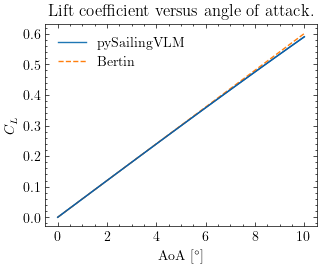

In [5]:
import matplotlib.pyplot as plt
import scienceplots # sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended cm-super

plt.style.use('science')
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(AoA_degs, C_results, color='tab:blue', label='pySailingVLM')
ax.plot(AoA_degs, C_bertin, color='tab:orange', linestyle='dashed', label='Bertin')

ax.set_xlabel(r"AoA [$^\circ$]")
ax.set_ylabel(r"$C_{L}$")

ax.set_title("Lift coefficient versus angle of attack.")
ax.legend()
plt.plot(AoA_degs, C_results)   
#plt.savefig('bertin_1.png')

In [6]:
import numpy as np
from pySailingVLM.solver.coefs import get_vlm_Cxyz

AoA_deg = 4.2
C = []
c_l = []
a_vlm = []

conditions.alpha_true_wind_deg = AoA_deg
solver.n_spanwise = 4

csys_transformations = CSYS_transformations(conditions.heel_deg, conditions.leeway_deg, v_from_original_xyz_2_reference_csys_xyz=csys.reference_level_for_moments)

w = Wind(conditions)
s = Sail(solver, rig, main, jib, csys_transformations)
sail_set = s.sail_set
myvlm = Vlm(sail_set.panels, solver.n_chordwise, solver.n_spanwise, conditions.rho, w.profile, sail_set.trailing_edge_info, sail_set.leading_edge_info)

height = 1.0
sails_Cxyz = myvlm.get_Cxyz(w, height)
 
for idx, Cxyz in enumerate(sails_Cxyz):
    a = Cxyz[1] / np.deg2rad(AoA_deg)
    C.append(Cxyz[1])
    a_vlm.append(a)

In [7]:
def calculate_ydata(gamma, CL, cav, wind, height):
    V = np.array(wind.profile.get_true_wind_speed_at_h(height))
    return 2 * gamma / (np.linalg.norm(V) * cav * CL)

N = int(sail_set.panels.shape[0] / 2)
cav = chord_length
y_data = np.array([calculate_ydata(myvlm.gamma_magnitude[i], C[0], cav, w, height) for i in range(N)])
cp_y = np.split(myvlm.cp, 2)[0][:,2]
x_data = 2 * cp_y / (half_wing_span * 2)

In [8]:
g_good = np.array([0.0273, 0.0287, 0.0286, 0.0250])
ydata_good = 2 * 4 * 2 * half_wing_span * g_good / (1.096 * cav)
cp_y_good = np.array([0.0625, 0.1875, 0.3125, 0.4377])
x_good = 2*cp_y_good / (2*half_wing_span)

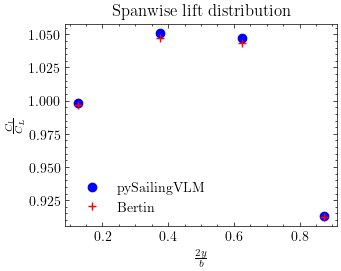

In [9]:
# importing matplotlib module
from matplotlib import pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(x_data, y_data, 'bo',label='pySailingVLM')
ax.plot(x_good, ydata_good,'r+', label='Bertin')

ax.set_xlabel(r"$\frac{2y}{b}$")
ax.set_ylabel(r"$\frac{C_{l}}{C_{L}}$")
ax.set_title("Spanwise lift distribution")
ax.legend()   
plt.savefig('bertin_2')

In [12]:
from pySailingVLM.solver.coefs import get_C
cl = get_C(myvlm.panels, myvlm.areas, myvlm.lift, myvlm.inlet_conditions.V_app_infs, myvlm.n_spanwise, myvlm.n_chordwise, myvlm.rho)
cd = get_C(myvlm.panels, myvlm.areas, myvlm.drag, myvlm.V_induced_at_cp, myvlm.n_spanwise, myvlm.n_chordwise, myvlm.rho)

In [17]:
myvlm.force

array([[-0.00015253,  0.00313307,  0.00015253],
       [-0.00019685,  0.00329752,  0.00019685],
       [-0.00020653,  0.00328694,  0.00020653],
       [-0.00019282,  0.00286553,  0.00019282],
       [-0.00019282,  0.00286553, -0.00019282],
       [-0.00020653,  0.00328694, -0.00020653],
       [-0.00019685,  0.00329752, -0.00019685],
       [-0.00015253,  0.00313307, -0.00015253]])

In [18]:
myvlm.lift

array([[-0.00023005,  0.00313265,  0.00023005],
       [-0.00024211,  0.00329685,  0.00024211],
       [-0.00024129,  0.0032858 ,  0.00024129],
       [-0.00021034,  0.00286423,  0.00021034],
       [-0.00021034,  0.00286423, -0.00021034],
       [-0.00024129,  0.0032858 , -0.00024129],
       [-0.00024211,  0.00329685, -0.00024211],
       [-0.00023005,  0.00313265, -0.00023005]])

In [19]:
myvlm.drag

array([[ 7.75220772e-05,  4.18161053e-07, -7.75220772e-05],
       [ 4.52585775e-05,  6.69261149e-07, -4.52585775e-05],
       [ 3.47646229e-05,  1.13556079e-06, -3.47646229e-05],
       [ 1.75196473e-05,  1.30008302e-06, -1.75196473e-05],
       [ 1.75196473e-05,  1.30008302e-06,  1.75196473e-05],
       [ 3.47646229e-05,  1.13556079e-06,  3.47646229e-05],
       [ 4.52585775e-05,  6.69261149e-07,  4.52585775e-05],
       [ 7.75220772e-05,  4.18161053e-07,  7.75220772e-05]])

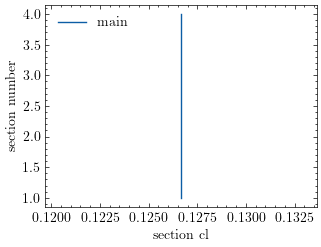

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
section_number = np.arange(1, myvlm.n_spanwise+1, 1)

fig = plt.figure()
ax1 = fig.add_subplot(111)

#ax1.plot(cl[0], section_number, label='jib')
ax1.plot(cl[0],section_number, label='main')
plt.ylabel('section number')
plt.xlabel('section cl')
plt.legend(loc='upper left')
plt.show()